# Interannual varability in GIMMS-PKU-consolidated

Check the IAV of GIMMS-PKU-consolidated through the whole 40-year archive by plotting standardised anomalies

In [1]:
import numpy as np
import xarray as xr
import seaborn as sb
import pandas as pd
import geopandas as gpd
from scipy import stats
import scipy.signal
import xskillscore as xs
import matplotlib as mpl
from matplotlib.cm import ScalarMappable
import contextily as ctx
import matplotlib.pyplot as plt
from odc.geo.xr import assign_crs
from matplotlib.ticker import FormatStrFormatter
from xarrayMannKendall import Mann_Kendall_test

import sys
sys.path.append('/g/data/os22/chad_tmp/AusEFlux/src/')
from _utils import round_coords

sys.path.append('/g/data/os22/chad_tmp/dea-notebooks/Tools/')
from dea_tools.spatial import xr_rasterize
from dea_tools.temporal import xr_phenology

# Using ggplot styles in this notebook
plt.style.use('ggplot')

%matplotlib inline

## Analysis Parameters

In [2]:
model_var='NDVI'
crs='epsg:4326'
base = '/g/data/os22/chad_tmp/AusENDVI/data/'

## Open datasets

In [3]:
pku = xr.open_dataarray(base+'/NDVI_harmonization/AVHRR_GIMMS-PKU-MODIS_1982_2022.nc')
pku = assign_crs(pku, crs=crs)
pku.attrs['nodata'] = np.nan

# merge = xr.open_dataset(f'{base}NDVI_harmonization/LGBM/NDVI_CLIM_LGBM_5km_monthly_1982_2022_wGaps.nc')['NDVI']
merge = xr.open_dataset(f'{base}/NDVI_harmonization/LGBM/NDVI_CLIM_LGBM_5km_monthly_1982_2022_noGaps.nc')['NDVI']
merge = assign_crs(merge, crs=crs)
merge.attrs['nodata'] = np.nan
merge = merge.rename('NDVI')

rain = xr.open_dataset('/g/data/os22/chad_tmp/climate-carbon-interactions/data/5km/rain_5km_monthly_1981_2022.nc').rain
rain = assign_crs(rain, crs=crs)
rain.attrs['nodata'] = np.nan

## Match datasets

In [4]:
merge = merge.odc.reproject(pku.odc.geobox, resampling='average')
rain = rain.odc.reproject(pku.odc.geobox, resampling='average')
merge = round_coords(merge)
pku = round_coords(pku)
rain = round_coords(rain)

In [5]:
avhrr_mask =  ~np.isnan(merge)
del avhrr_mask.attrs['nodata']
avhrr_mask = assign_crs(avhrr_mask, crs=crs)

pku_mask =  ~np.isnan(pku)
del pku_mask.attrs['nodata']
pku_mask = assign_crs(pku_mask, crs=crs)

#combine masks
mask = (avhrr_mask & pku_mask) # & cdr_mask

In [6]:
pku = pku.sel(time=pku.time).where(mask)
merge = merge.sel(time=pku.time).where(mask)
rain = rain.sel(time=pku.time).where(mask)

merge = merge.rename({'latitude':'y', 'longitude':'x'})
pku = pku.rename({'latitude':'y', 'longitude':'x'})
rain = rain.rename({'latitude':'y', 'longitude':'x'})

## Rolling mean anomalies

In [10]:
import warnings
warnings.simplefilter('ignore')

#standardized anom
def stand_anomalies(ds):
    return xr.apply_ufunc(
        lambda x, m, s: (x - m) / s,
            ds.groupby("time.month"),
            ds.groupby("time.month").mean(),
            ds.groupby("time.month").std()
    )
    
rain_std_anom = stand_anomalies(rain)
pku_std_anom = stand_anomalies(pku)
merge_std_anom = stand_anomalies(merge)

In [25]:
roll=3

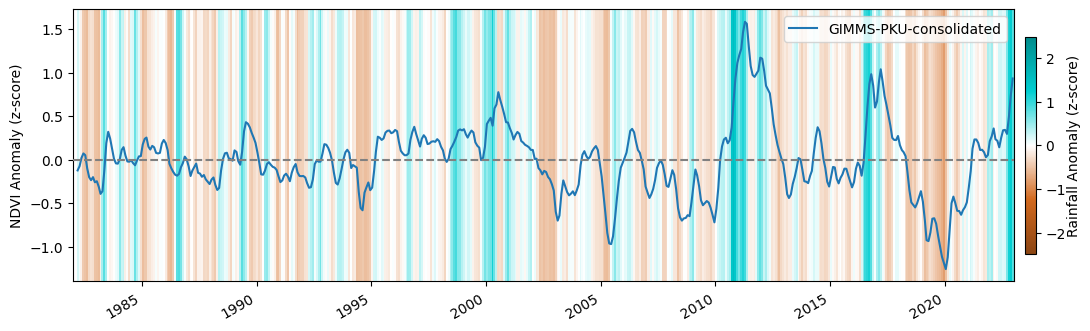

In [27]:
rain_df = rain_std_anom.rename('rain').rolling(time=roll,
                min_periods=roll).mean().mean(['x','y']).to_dataframe().drop(['spatial_ref', 'month'], axis=1)

plt.style.use('default')
fig, ax = plt.subplots(1,1, figsize=(14,4))
ax2 = ax.twinx()

pku_std_anom.drop('month').rolling(time=roll, min_periods=roll).mean().mean(['x','y']).plot(ax=ax, label='GIMMS-PKU-consolidated')

norm=plt.Normalize(-2.5,2.5)
cmap = mpl.colors.LinearSegmentedColormap.from_list("", ['saddlebrown','chocolate','white','darkturquoise','darkcyan'], N=256)

# Plot bars
bar = ax2.bar(rain_df.index, 1, color=cmap(norm(rain_df['rain'])), width=32)
sm = ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])
cbar = plt.colorbar(sm, shrink=0.8, pad=0.01)
cbar.set_label('Rainfall Anomaly (z-score)',labelpad=.5)

ax2.set_zorder(ax.get_zorder()-1)
ax.set_frame_on(False)
ax.axhline(0, c='grey', linestyle='--')

# Reformat y-axis label and tick labels
ax.set_ylabel(model_var+' Anomaly (z-score)')
ax.set_xlabel('')
ax2.set_ylabel('')
ax2.set_yticks([])
ax2.set_ylim([0, 1]) 
# ax.set_ylim([-1.25, 1.25])
ax.margins(x=0)
ax2.margins(x=0)

# Adjust the margins around the plot area
plt.subplots_adjust(left=0.1, right=None, top=None, bottom=0.2, wspace=None, hspace=None)

ax.legend()
ax.set_title(None);
fig.savefig("/g/data/os22/chad_tmp/AusENDVI/results/figs/Australian_NDVI_compare_PKU_"+str(roll)+"Mrollingmean.png",
            bbox_inches='tight', dpi=300)